# Deploy Pretrained GP Model on a Selected SP

## 1. Import Libraries

In [1]:
# General
import os
import warnings
import time
import sys

# Specific
import numpy as np
import pandas as pd
import gpflow
from gpflow.utilities import print_summary
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from matplotlib import rc
import seaborn as sns

2025-01-29 13:14:02.138436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Configuration

In [58]:
# =============================================================================
# Plot Configuration
# =============================================================================
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
plt.rcParams["font.family"] = "Serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
rc('axes', labelsize='12', labelweight='bold')
rc('xtick', labelsize='11')
rc('ytick', labelsize='11')
rc('legend', fontsize='10')
mpl.rcParams['lines.linewidth'] = 2
plt.rcParams["savefig.pad_inches"]=0.02

In [59]:
# Define normalization methods (COPIED FROM GP TRAINING FILE)
featureNorm=None            # None,Standardization,MinMax,LogStand,Log+bStand
labelNorm='Standardization' # None,Standardization,MinMax,LogStand,Log+bStand

# GP Configuration (COPIED FROM GP TRAINING FILE)
gpConfig={'kernel':'RBF',
          'useWhiteKernel':True,
          'trainLikelihood':True,
          'alpha':10**-2}

# define path to SP dataset 
sp_dataset_path = "sp_hf_svp_yk.csv"

# Get target variable/property name, dataset codes, and display units
var_names=['Molar Mass', 'Boiling Point', 'Density at 20°C', 'RI at 20°C', '$S_{aq}$ at 25°C (g/kg)', 'Vapor Pressure']
codes = ['MM', 'BP', 'D_20', 'RI_20', 'S_25', 'VP']
var_units=['g/mol', '°C', 'g/cm³', 'RI', 'g/kg', 'Pa']
num_props = len(var_names)

# define path to target dataset 
prop_dataset_path = "GP-Training-HF_yk/k-fold-Traget-Databases"

# define results and dataset folders
models_folder = 'GP-Training-HF_yk/optimized_models'


In [60]:
# selected molecule index
mol_idx = 481

# selected target property index
code = 'BP'
prop_idx = codes.index(code)
var_name = var_names[prop_idx]
var_unit = var_units[prop_idx]

## 3. Functions

In [61]:
def load_gp_model(model_file):
    with open(model_file, "rb") as f:
        loaded_model = pickle.load(f)
    return loaded_model

def load_scaler(scaler_file):
    with open(scaler_file, "rb") as f:
        X_train_scaler, Y_train_scaler, featureNorm, labelNorm = pickle.load(f)
    return X_train_scaler, Y_train_scaler, featureNorm, labelNorm

def get_mol_sp(sp_database, mol_idx):
    """Extract sigma profile for a selected molecule from a
      provided sigma profile database
    Args:
        sp_database: str, path to the sigma profile database
        mol_idx: int, molecule index
    Returns:
        sigma: np.array (Nbins,1), sigma values
        sp: np.array (Nbins,1), sigma profile
        mol_name: str, molecule name
    """
    data = pd.read_csv(sp_database, index_col=0)
    mol_names = data['Name']
    # remove unneeded columns
    unneeded_cols = ['CAS Number', 'Name', 'Notes']
    for unneeded_col in unneeded_cols:
        try:
            data = data.drop(columns=unneeded_col)
        except:
            pass
    # get all sigma values
    sigma = data.keys().to_numpy().astype(float)
    sigma = np.round(sigma, 3)
    # get sigma profile for the molecule
    sp = data.loc[mol_idx].to_numpy()
    # get molecule name
    mol_name = mol_names[mol_idx]
    return sigma, sp, mol_name

def get_mol_prop(mol_idx, prop_dataset_folder, prop_code, kfold, 
                 dataset='original', LOUD=False):
    """Extract ground truth property value for a selected molecule index
    Args:
        mol_idx: int, molecule index
        prop_dataset_folder: str, path to the folder containing the property dataset
        prop_code: str, property code
        kfold: int, k-fold index
        dataset: str, dataset type (test, train, original)
        LOUD: bool, print messages
    Returns:
        prop_val: float, property value for the selected molecule index
    """
    if dataset.lower() == 'test':
        prop_file = f"{prop_dataset_folder}/{prop_code}_mlDatabase_TestSet_{kfold}.csv"
    elif dataset.lower() == 'train':
        prop_file = f"{prop_dataset_folder}/{prop_code}_mlDatabase_TrainSet_{kfold}.csv"
    elif dataset.lower() == 'original':
        prop_file = f"{prop_dataset_folder}/{prop_code}_mlDatabase_Original.csv"

    prop = pd.read_csv(prop_file, index_col=0)
    indices = prop.index
    # remove unwanted columns
    unneeded_cols = ['CAS Number', 'Name', 'Notes']
    for unneeded_col in unneeded_cols:
        try:
            prop = prop.drop(columns=unneeded_col)
        except:
            pass
    properties = prop.iloc[:, 0]
    # check if molecule index is in the properties
    if mol_idx in indices:
        # find property value for the molecule
        prop_val = properties[mol_idx]
        return prop_val
    else:
        if LOUD: print(f'Molecule index {mol_idx} not found in the properties database: {prop_file}')
        return None

def normalize(inputArray,skScaler=None,method='Standardization',reverse=False,warn=True):
    """
    normalize() normalizes (or unnormalizes) inputArray using the method
    specified and the skScaler provided.

    Parameters
    ----------
    inputArray : np array
        Array to be normalized. If dim>1, array is normalized column-wise.
    skScaler : scikit-learn preprocessing object or None
        Scikit-learn preprocessing object previosly fitted to data. If None,
        the object is fitted to inputArray.
        Default: None
    method : string, optional
        Normalization method to be used.
        Methods available:
            . Standardization - classic standardization, (x-mean(x))/std(x)
            . MinMax - scale to range (0,1)
            . LogStand - standardization on the log of the variable,
                         (log(x)-mean(log(x)))/std(log(x))
            . Log+bStand - standardization on the log of variables that can be
                           zero; uses a small buffer,
                           (log(x+b)-mean(log(x+b)))/std(log(x+b))
            . None - no normalization is performed.
        Default: 'Standardization'
    reverse : bool
        Whether  to normalize (False) or unnormalize (True) inputArray.
        Defalt: False
    warn : bool
        Whether to warn the user about reshaping the inputArray.
        Default : True

    Returns
    -------
    inputArray : np array
        Normalized (or unnormalized) version of inputArray.
    skScaler : scikit-learn preprocessing object
        Scikit-learn preprocessing object fitted to inputArray. It is the same
        as the inputted skScaler, if it was provided.

    """
    # If inputArray is a labels vector of size (N,), reshape to (N,1)
    if inputArray.ndim==1:
        inputArray=inputArray.reshape((-1,1))
        if warn:
            warnings.warn('Input to normalize() was of shape (N,). It was assumed'\
                        +' to be a column array and converted to a (N,1) shape.')
    # If no normalization is to be performed, return inputArray
    if method is None:
        return inputArray,skScaler
    # If skScaler is None, train for the first time
    if skScaler is None:
        # Check method
        if method=='Standardization' or method=='MinMax': aux=inputArray
        elif method=='LogStand': aux=np.log(inputArray)
        elif method=='Log+bStand': aux=np.log(inputArray+10**-3)
        else: raise ValueError('Could not recognize method in normalize().')
        if method!='MinMax':
            skScaler=preprocessing.StandardScaler().fit(aux)
        else:
            skScaler=preprocessing.MinMaxScaler().fit(aux)
    # Do main operation (normalize or unnormalize)
    if reverse:
        # Rescale the data back to its original distribution
        inputArray=skScaler.inverse_transform(inputArray)
        # Check method
        if method=='LogStand': inputArray=np.exp(inputArray)
        elif method=='Log+bStand': inputArray=np.exp(inputArray)-10**-3
    elif not reverse:
        # Check method
        if method=='Standardization' or method=='MinMax': aux=inputArray
        elif method=='LogStand': aux=np.log(inputArray)
        elif method=='Log+bStand': aux=np.log(inputArray+10**-3)
        else: raise ValueError('Could not recognize method in normalize().')
        inputArray=skScaler.transform(aux)
    # Return
    return inputArray,skScaler

def get_zero_cols(sp_dataset, prop_dataset, prop_code, LOUD=False):
    '''Read the SPs and property data from a specified dataset and return the all-zero columns
    Args:
        sp_dataset: str, path to the sigma profile dataset
        prop_dataset: str, path to the folder containing the property dataset
        prop_code: str, property code
    Returns:
        zero_col: np.array, column indices
    '''
    # read generated sigma profiles
    sp_gen = pd.read_csv(sp_dataset, index_col=0)

    # remove problematic molecules
    prob_mols = [690]
    for prob_idx in prob_mols:
        sp_gen = sp_gen.drop(index=prob_idx)

    # get all valid indices where sp_gen is not nan (x_data)
    valid_x_idx = sp_gen.index[~sp_gen.isna().any(axis=1)]

    # remove columns 1 and 2 and save them to variables
    sp_gen = sp_gen.drop(columns=['CAS Number', 'Name']) 

    # read target property
    prop = pd.read_csv(f'{prop_dataset}/{prop_code}_mlDatabase_Original.csv', index_col=0)
    try:
        prop = prop.drop(columns=['CAS Number', 'Name', 'Temperature /ºC']) # remove columns
    except:
        prop = prop.drop(columns=['CAS Number', 'Name'])
    prop = prop.iloc[:, 0]

    # get common indices between x and y
    y_idx = prop.index
    valid_idx = np.intersect1d(valid_x_idx, y_idx)

    # get x and y data for valid indices
    x_data = sp_gen.loc[valid_idx].to_numpy()
    y_data = prop.loc[valid_idx].to_numpy().reshape(-1, 1)

    # Remove comment columns from SPs, if any
    if type(x_data[1,-1]) == str:
        # remove comment columns
        x_data = x_data[:,:-1].astype(float)

    # find all-zero columns in x-data
    zero_col = np.where(~x_data.any(axis=0))[0]

    # if no all-zero columns are found, return an empy list
    if len(zero_col) == 0:
        return []
        
    # get only zero columns at the edges of the sigma profile
    z_1 = zero_col[0]
    z_2 = zero_col[-1]
    for z in zero_col:
        # compare z with z1
        if np.abs(z-z_1) <= 1:
            z_1 = z
    for z in reversed(zero_col):
        # compare z with z2
        if np.abs(z-z_2) <= 1:
            z_2 = z
    
    # update zero_col to remove columns between z1 and z2
    zero_col = zero_col[np.where((zero_col <= z_1) | (zero_col >= z_2))]

    if LOUD:
        print(f'Number of all-zero columns in {prop_code} dataset: {len(zero_col)}')

    return zero_col


## 4. GP Model Deployment


In [ ]:
# Get Molecule Sigma Profile
sigma, sp, mol_name = get_mol_sp(sp_dataset_path, mol_idx)

# Remove all-zero columns from the sigma profile
zero_cols = get_zero_cols(sp_dataset_path, prop_dataset_path, code)
sp = np.delete(sp, zero_cols)
sigma = np.delete(sigma, zero_cols)

# Get Molecule Property
prop_val = get_mol_prop(mol_idx, prop_dataset_path, code, 0, dataset='original', LOUD=False)

# Initialize container for predictions
prop_predictions = np.zeros(10)
prop_variances = np.zeros(10)

# Loop over k-folds (different datasplits yield different GP models)
for k in range(10):
    # Load GP model
    model_file = f"{models_folder}/{code}_model_{k}.pkl"
    gp_model = load_gp_model(model_file)
    # Load scaler
    scaler_file = f"{models_folder}/{code}_scaler_{k}.pkl"
    X_train_scaler, Y_train_scaler, featureNorm, labelNorm = load_scaler(scaler_file)

    # Normalize sigma profile
    sp_norm, _ = normalize(sp, X_train_scaler, featureNorm, reverse=False, warn=False)

    # Predict property
    prop_pred, prop_var = gp_model.predict_f(sp_norm.reshape(1, -1))

    # Unnormalize prediction
    prop_pred, _ = normalize(prop_pred, Y_train_scaler, labelNorm, reverse=True)
    prop_var, _ = normalize(prop_var, Y_train_scaler, labelNorm, reverse=True)

    # Resize prediction and variance from (1,1) array to float
    prop_pred = prop_pred[0,0]
    prop_var = prop_var[0,0]
    
    # Print results
    print(f"\nFold #{k+1}:")
    print(f"\tPredicted {var_name}: {prop_pred:.2f} ± {np.sqrt(prop_var):.2f} {var_unit}")
    print(f"\tGround Truth {var_name}: {prop_val:.2f} {var_unit}")
    print(f"\tRelative Absolute Error: {np.abs(prop_pred - prop_val)/prop_val*100:.2f} %")

    # Save predictions
    prop_predictions[k] = prop_pred
    prop_variances[k] = prop_var



Fold #1:
	Predicted Boiling Point: 110.82 ± 12.66 °C
	Ground Truth Boiling Point: 117.60 °C
	Relative Absolute Error: 5.76 %

Fold #2:
	Predicted Boiling Point: 110.61 ± 12.66 °C
	Ground Truth Boiling Point: 117.60 °C
	Relative Absolute Error: 5.95 %

Fold #3:
	Predicted Boiling Point: 112.53 ± 12.61 °C
	Ground Truth Boiling Point: 117.60 °C
	Relative Absolute Error: 4.31 %

Fold #4:
	Predicted Boiling Point: 114.26 ± 12.63 °C
	Ground Truth Boiling Point: 117.60 °C
	Relative Absolute Error: 2.84 %

Fold #5:
	Predicted Boiling Point: 112.57 ± 12.65 °C
	Ground Truth Boiling Point: 117.60 °C
	Relative Absolute Error: 4.28 %

Fold #6:
	Predicted Boiling Point: 113.67 ± 12.71 °C
	Ground Truth Boiling Point: 117.60 °C
	Relative Absolute Error: 3.34 %

Fold #7:
	Predicted Boiling Point: 114.39 ± 12.64 °C
	Ground Truth Boiling Point: 117.60 °C
	Relative Absolute Error: 2.73 %

Fold #8:
	Predicted Boiling Point: 113.67 ± 12.65 °C
	Ground Truth Boiling Point: 117.60 °C
	Relative Absolute Error:

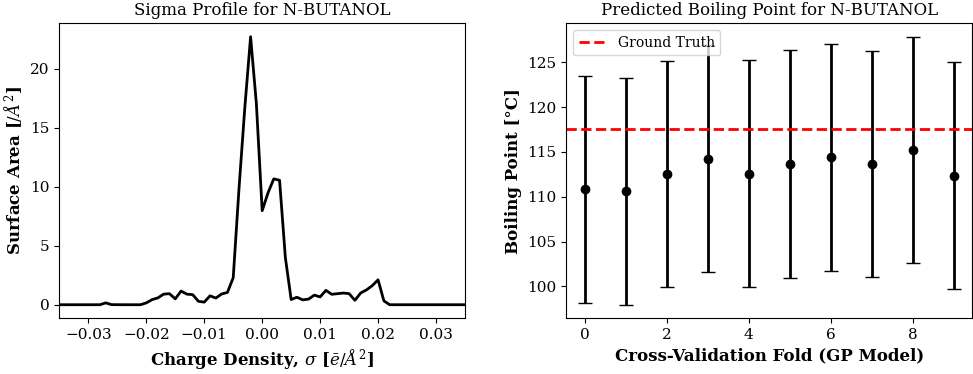

In [63]:
# Plot Sigma Profile and results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot Sigma Profile
ax = axs[0]
ax.plot(sigma, sp, 'k-')
ax.set_xlabel(r'Charge Density, $\sigma$ [$\bar{e}/\AA^2$]')
ax.set_ylabel(r'Surface Area [$/\AA^2$]')
ax.set_title(f'Sigma Profile for {mol_name}')
ax.set_xlim([-0.035, 0.035])

# Plot property predictions
ax = axs[1]
ax.errorbar(range(10), prop_predictions, yerr=np.sqrt(prop_variances), fmt='o', color='k', capsize=5)
ax.axhline(y=prop_val, color='r', linestyle='--', label='Ground Truth')
ax.set_xlabel('Cross-Validation Fold (GP Model)')
ax.set_ylabel(f'{var_name} [{var_unit}]')
ax.set_title(f'Predicted {var_name} for {mol_name}')
ax.legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()